In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rpy2.robjects as ro
from functools import partial
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.ipython import html
html.html_rdataframe = partial(html.html_rdataframe, table_class = "docutils")
%load_ext rpy2.ipython

In [2]:
%%R
library(mlbench)
datasetxor <- mlbench.xor(300)
XR_datasetxor <- datasetxor$x
LABELSR_datasetxor<- datasetxor$classes

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [3]:
from rpy2.robjects import numpy2ri
numpy2ri.activate()
x_df_xor = np.array(ro.r['XR_datasetxor'])
labels_df_xor = np.array(ro.r['LABELSR_datasetxor'])
labels_df_xor[labels_df_xor == 1] = -1
labels_df_xor[labels_df_xor == 2] = 1

In [4]:
from sklearn.model_selection import train_test_split
X_trainxor, X_testxor, y_trainxor, y_testxor = train_test_split(x_df_xor, labels_df_xor, random_state = 0, train_size = 0.8)

In [5]:
def train_ELM(xin : np.ndarray, yin : np.ndarray, p : int, control : bool) -> list:
    n = xin.shape[1]
    
    if control == True:
        Z = np.array([np.random.uniform(-0.5, 0.5) for _ in range((n + 1) * p)]).reshape(n + 1, -1)
        ones = np.ones((xin.shape[0], 1))
        xin = np.concatenate((xin,ones), axis = 1)
    else:
        Z = np.array([np.random.uniform(-0.5, 0.5) for _ in range(n * p)]).reshape(n , -1)

    H = np.tanh(np.dot(xin, Z))
    ones = np.ones((H.shape[0], 1))
    H = np.concatenate((H, ones), axis = 1)


    w = np.dot(np.linalg.pinv(H), yin)

    return_list = []
    return_list.append(w)   
    return_list.append(H)
    return_list.append(Z)
    return  return_list



def test_ELM(xin: np.ndarray, Z: np.ndarray, W: np.ndarray, control: bool):
    
    if control == True:
        ones = np.ones((xin.shape[0], 1))
        xin = np.concatenate((xin, ones), axis = 1)
    H = np.tanh(np.dot(xin, Z))
    ones = np.ones((H.shape[0], 1))
    H = np.concatenate((H, ones), axis = 1)
    Y_hat = np.sign(np.dot(H, W))
    return Y_hat

In [6]:
pxor = 100
ret = train_ELM(X_trainxor, y_trainxor, pxor, control = True)
wxor = ret[0]
hxor = ret[1]
zxor = ret[2]
y_pred = test_ELM(xin = X_testxor, Z = zxor, W = wxor, control = True)

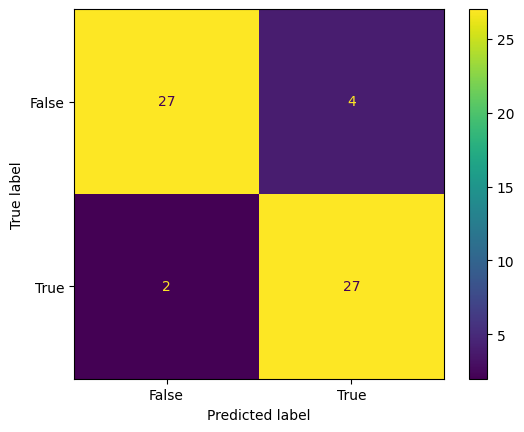

In [7]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_testxor, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [8]:
labels_df_reshaped = labels_df_xor.reshape(-1, 1)
mat_plot = np.concatenate((x_df_xor, labels_df_reshaped), axis = 1)
index_sort = 2
sorted_indices = np.argsort(mat_plot[:, index_sort])
mat_plot = mat_plot[sorted_indices]

In [9]:
np.unique(mat_plot[:, 2], return_counts = True)

(array([-1.,  1.]), array([147, 153]))

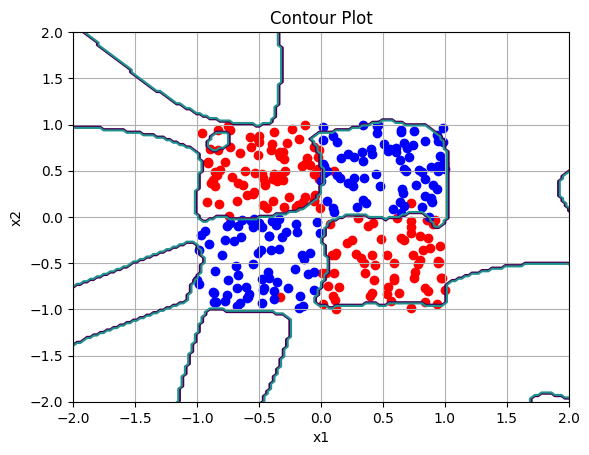

In [10]:
seqx1x2 = np.linspace(start = -4, stop = 4, num = 300)
np_grid = seqx1x2.shape[0]
shape = (np_grid, np_grid)
MZ = np.zeros(shape)
for i in range(np_grid):
    for j in range(np_grid):
        x1 = seqx1x2[i]
        x2 = seqx1x2[j]
        x1x2 = np.column_stack((x1, x2, 1))
        h1 = np.tanh(np.dot(x1x2, zxor))
        h1 = np.column_stack((h1, np.ones_like(h1[:, 0])))
        MZ[i, j] = np.sign(np.dot(h1, wxor))[0]

x1_points = mat_plot[: 150, 0 : 2]
x2_points = mat_plot[150 :, 0 : 2]
plt.contour(seqx1x2, seqx1x2, MZ, levels = 1)
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

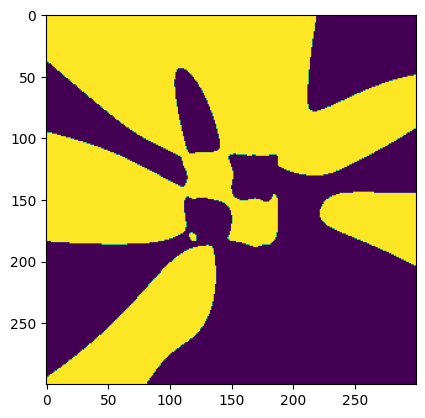

In [11]:
plt.imshow(MZ)